<a href="https://colab.research.google.com/github/sota1111/DL_Zero/blob/main/DL_Zero1_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os, sys
os.chdir('/content/drive/MyDrive/FromScratch')

In [ ]:
import numpy as np
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

In [ ]:
class MulLayer:
  def __init__(self):
    self.x = None
    self.y = None

  def forward(self, x, y):
    self.x = x
    self.y = y
    out = x * y

    return out

  def backward(self, dout):
    dx = dout * self.y # xとyをひっくり返す
    dy = dout * self.x

    return dx, dy

In [ ]:
apple = 100
apple_num = 2
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
price = mul_tax_layer.forward(apple_price, tax)

print(price)

220.00000000000003


In [ ]:
# backward
dprice = 1
dapple_price, dtax = mul_tax_layer.backward(dprice)
dapple, dapple_num =mul_apple_layer.backward(dapple_price)
print(dapple, dapple_num, dtax)

2.2 110.00000000000001 200


In [ ]:
class AddLayer:
  def __init__(self):
    pass

  def forward(self, x, y):
    out = x + y
    return out

  def backward(self, dout):
    dx = dout * 1
    dy = dout * 1
    return dx, dy


In [ ]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

# layer
mul_apple_layer = MulLayer()
mul_orange_layer = MulLayer()
add_apple_orange_layer = AddLayer()
mul_tax_layer = MulLayer()

# forward
apple_price = mul_apple_layer.forward(apple, apple_num)
orange_price = mul_orange_layer.forward(orange, orange_num)
all_price = add_apple_orange_layer.forward(apple_price, orange_price)
price = mul_tax_layer.forward(all_price, tax)

# backward
dprice = 1
dall_price, dtax = mul_tax_layer.backward(dprice)
dapple_price, dorange_price = add_apple_orange_layer.backward(dall_price)
dorange, dorange_num = mul_orange_layer.backward(dorange_price)
dapple, dapple_num = mul_apple_layer.backward(dapple_price)

print(price)
print(dapple_num, dapple, dorange, dorange_num, dtax)

715.0000000000001
110.00000000000001 2.2 3.3000000000000003 165.0 650


In [ ]:
class Relu:
  def __init__(self):
    self.mask = None

  def forward(self, x):
    self.mask = (x <= 0)
    out = x.copy()
    out[self.mask] = 0

    return out

  def backward(self, dout):
    dout[self.mask] = 0
    dx = dout

    return dx

In [ ]:
x = np.array([[1.0, -0.5], [-2.0, 3.0]])
print(x)

[[ 1.  -0.5]
 [-2.   3. ]]


In [ ]:
mask = (x <= 0)
mask

array([[False,  True],
       [ True, False]])

In [ ]:
class Sigmoid:
  def __init__(self):
    self.out = None

  def forward(self, x):
    out = 1 /(1 + np.exp(-x))
    self.out = out

    return out

  def backward(self, dout):
    dx = dout * (1.0 - self.out) * self.out

    return dx

# 5.6 Affine/Softmaxレイヤの実装

In [ ]:
X = np.random.rand(2)
W = np.random.rand(2,3)
B = np.random.rand(3)

x.shape
W.shape
B.shape

Y = np.dot(X, W) + B

In [ ]:
class Affine:
  def __init__(self, W, b):
    self.W = W
    self.b = b
    self.x = None
    self.dW = None
    self.db = None
  
  def forward(self, x):
    self.x = x
    out = np.dot(x, self.w) + self.b

    return out

  def backward(self, dout):
    dx = np.dot(dout, self.W.T)
    self.dW = np.dot(self.x, dout)
    self.db = np.sum(dout, axis=0)

    return dx

In [ ]:
def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # オーバーフロー対策
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y, t):
    if y.ndim == 1:
        t = t.reshape(1, t.size)
        y = y.reshape(1, y.size)
        
    # 教師データがone-hot-vectorの場合、正解ラベルのインデックスに変換
    if t.size == y.size:
        t = t.argmax(axis=1)
             
    batch_size = y.shape[0]
    return -np.sum(np.log(y[np.arange(batch_size), t] + 1e-7)) / batch_size

In [ ]:
class SoftmaxWithLoss:
  def __init__(self):
    self.loss = None
    self.y = None
    self.t = None

  def forward(self, x, t):
    self.f = t
    self.y = softmax(x)
    self.loss = cross_entropy_error(self.y, self.f)

    return self.loss

  def backward(self, dout=1):
    batch_size = self.t.shape[0]
    dx = (self.y - self.t) / batch_size

    return dx

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from common.layers import *
from common.gradient import numerical_gradient
from collections import OrderedDict

class TwoLayerNet:

  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    # 重みの初期化
    self.params = []
    self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params['b1'] = np.zeros(hidden_size)
    self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params['b2'] = np.zeros(output_size)

    # レイヤの生成
    self.layers = OrderedDict()
    self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
    self.layers['Relu1'] = Relu()
    self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

    self.lastLayer = SoftmaxWithLoss()

  def predict(self, x):
    for layer in self.layers.values():
      x = layer.forward(x)

    return x

  # x:入力データ、y:教師データ
  def loss(self, x, t):
    y = self.predict(x)
    return self.lastLayer.forward(y, t)

  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y, axis=1)
    if t.ndim != 1:
      t = np.argmax(t, np.argmax(t, axis=1))
    accuracy = np.sum(y==t) / float(x.shape[0])
    return accuracy

  # x:入力データ、t:教師データ
  def numerical_gradient(self, x, t):
    loss_W = lambda W:self.loss(x, t)

    grads = {}
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
    grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
    grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
    grads['b2'] = numerical_gradient(loss_W, self.params['b2'])

    return grads

  def gradient(self, x, t):
    # forward
    self.loss(x, t)

    #backward
    dout = 1
    dout = self.lastLayer.backward(dout)

    layers = list(self.layers.values())
    layers.reverse()
    for layer in layers:
      dout = layer.backward(dout)

    # 設定
    grads = {}
    grads['W1'] = self.layers['Affine1'].dW
    grads['b1'] = self.layers['Affine1'].db
    grads['W2'] = self.layers['Affine2'].dW
    grads['b2'] = self.layers['Affine2'].db

    return grads

In [ ]:
import sys, os
sys.path.append(os.pardir)
import numpy as np
from dataset.mnist import load_mnist
from ch05.two_layer_net import TwoLayerNet

# データの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

x_batch = x_train[:3]
t_batch = t_train[:3]

grad_numerical = network.numerical_gradient(x_batch, t_batch)
grad_backprop = network.gradient(x_batch, t_batch)

# 各重みの絶対誤差の平均を求める
for key in grad_numerical.keys():
  diff = np.average(np.abs(grad_backprop[key] - grad_numerical[key]))
  print(key + ":" + str(diff))

W1:3.860466854417203e-10
b1:2.4309086812371228e-09
W2:5.543732839200882e-09
b2:1.400141531743282e-07


In [ ]:
import numpy as np
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

#ハイパーパラメータ
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []
# １エポックあたりの繰り返し数
iter_per_epoch = max(train_size / batch_size,1)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

for i in range(iters_num):
  # ミニバッチの取得
  batch_mask = np.random.choice(train_size, batch_size)
  x_batch = x_train[batch_mask]
  t_batch = t_train[batch_mask]

  # 勾配の計算
  #grad = network.numerical_gradient(x_batch, t_batch)
  grad = network.gradient(x_batch, t_batch)

  # パラメータの更新
  for key in ('W1', 'b1', 'W2', 'b2'):
    network.params[key] -= learning_rate * grad[key]

  # 学習経過の記録
  loss = network.loss(x_batch, t_batch)
  train_loss_list.append(loss)

  # １エポック五のに認識精度を計算
  if i % iter_per_epoch == 0:
    train_acc = network.accuracy(x_train, t_train)
    test_acc = network.accuracy(x_test, t_test)
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    test_acc_list.append(test_acc)
    print("train acc, test acc | " + str(train_acc) + ", "+ str(test_acc))

train acc, test acc | 0.10566666666666667, 0.1125
train acc, test acc | 0.9019333333333334, 0.9021
train acc, test acc | 0.9191666666666667, 0.9232
train acc, test acc | 0.9353166666666667, 0.9345
train acc, test acc | 0.9444833333333333, 0.9437
train acc, test acc | 0.9512333333333334, 0.9498
train acc, test acc | 0.9571333333333333, 0.9527
train acc, test acc | 0.9622333333333334, 0.9585
train acc, test acc | 0.9644833333333334, 0.9578
train acc, test acc | 0.9682333333333333, 0.963
train acc, test acc | 0.97015, 0.9627
train acc, test acc | 0.9729333333333333, 0.9662
train acc, test acc | 0.9726333333333333, 0.9653
train acc, test acc | 0.9750333333333333, 0.9688
train acc, test acc | 0.9771, 0.9695
train acc, test acc | 0.9777333333333333, 0.9672
train acc, test acc | 0.9790333333333333, 0.969


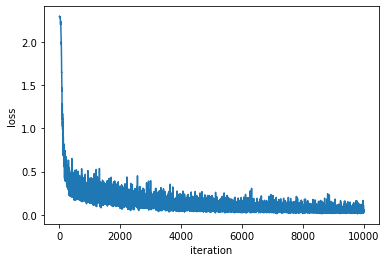

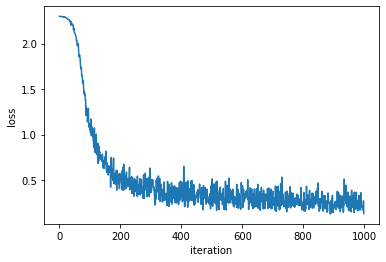

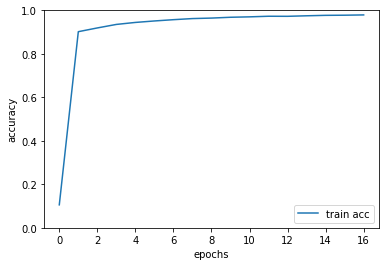

In [ ]:
# グラフの描画
import matplotlib.pylab as plt
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(range(iters_num), train_loss_list)
plt.xlabel("iteration")
plt.ylabel("loss")
plt.figure()

plt.plot(range(iters_num)[:1000], train_loss_list[:1000])
plt.xlabel("iteration")
plt.ylabel("loss")
plt.figure()

plt.plot(x, train_acc_list, label='train acc')
#plt.plot(x, test_acc_list, label='test acc', linestyle='--')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()